# Mander's Correlation Coefficients

<div class="custom-button-row">
    <a 
        class="custom-button custom-download-button" href="../../../notebooks/08_colocalization/pixel_intensity_based_colocalization_manders.ipynb" download>
        <i class="fas fa-download"></i> Download this Notebook
    </a>
    <a
    class="custom-button custom-download-button" href="https://colab.research.google.com/github/HMS-IAC/bobiac/blob/gh-pages/colab_notebooks/08_colocalization/pixel_intensity_based_colocalization_manders.ipynb" target="_blank">
        <img class="button-icon" src="../../../_static/logo/icon-google-colab.svg" alt="Open in Colab">
        Open in Colab
    </a>
</div>

In [ ]:
# /// script
# requires-python = ">=3.12"
# dependencies = [
#     "matplotlib",
#     "ndv[jupyter,vispy]",
#     "scikit-image",
#     "scipy",
#     "tifffile",
#     "imagecodecs",
#     "tqdm",
# ]
# ///

## Description

In this notebook, we will explore how to implement **Mander's Correlation Coefficients** in Python, a common method for quantifying colocalization based on pixel intensities.

```{warning}
NOTE: This notebook aims to show how to practically implement these methods but does not aim to describe when to use this method. The images used have been selected to showcase the practical implementation of the methods.
```

```{note}
In this example, we will not perform any image processing steps before computing the Mander's Correlation Coefficients. However, when conducting a real colocalization analysis you should consider applying some image processing steps to clean the images before computing the Mander's Correlation Coefficients, such as background subtraction, flat-field correction, etc.
```

## Mander's Correlation Coefficients

Mander's correlation coefficients can be used to quantify the degree of colocalization between two channels (or images). These coefficients, M1 and M2, are calculated based on the pixel intensities of the two channels and for this reason, they are different from a simple area overlap.

**M1** measures the **fraction of channel 1 intensity that co-occurs with channel 2**:
- **Numerator**: Sum of channel 1 intensities in pixels where both channels are above their thresholds
- **Denominator**: Sum of all channel 1 intensities above threshold

**M2** measures the **fraction of channel 2 intensity that co-occurs with channel 1**:
- **Numerator**: Sum of channel 2 intensities in pixels where both channels are above their thresholds
- **Denominator**: Sum of all channel 2 intensities above threshold

<div> <img src="https://raw.githubusercontent.com/HMS-IAC/bobiac/main/_static/images/coloc/manders_slide.png" alt="Ilastik Logo" width="800"></div>

For this exercise, we will analyze an image of a HeLa cell stained with two fluorescent markers: **channel 1** labels **endosomes** and **channel 2** labels **lysosomes**. 

From a biological perspective, lysosomes are typically found within or closely associated with endosomal compartments, while endosomes have a broader cellular distribution. Based on this biology, we expect:

- **High M2 coefficient**: Most lysosomal signal should colocalize with endosomal regions
- **Lower M1 coefficient**: Only a subset of endosomal signal should colocalize with lysosomes, since endosomes are more widely distributed throughout the cell.

### Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import ndv
import numpy as np
import tifffile
from scipy.stats import pearsonr
from skimage.filters import threshold_otsu
from tqdm import tqdm

### Load and Visualize the Image

In [ ]:
# Open the image
img_path = "../../_static/images/coloc/14na_z4.tif"
img = tifffile.imread(img_path)

In [ ]:
# Visualize the image
ndv.imshow(img)

In [ ]:
viewer = ndv.imshow(img)

In [ ]:
viewer.widget().children[1].snapshot()

To compute Mander's Correlation Coefficients, we need **two separate images** (channels). 

What is the image shape? How do we split the channels?

In [ ]:
# Get image shape
print("Image shape:", img.shape)

In [ ]:
# Split the image into channels
ch1 = img[0]
ch2 = img[1]

### Calculate Numerators and Denominators for Mander's Correlation Coefficients

The first and key step is to calculate **$R_i^{}$** and **$G_i^{}$** and thus to select which areas of each channel we want to consider for the colocalization analysis. This means we first need to **threshold each images to select only the pixels we want to consider**.

It is therefore evident that Mander's Correlation Coefficients are **sensitive to thresholding**, the way you decide to threshold your images will have a large impact on the results.

For this example, we will first use a simple Otsu thresholding method and later in the notebook we will explore a more automated way of selecting the threshold.

In [ ]:
# Create binary masks based on thresholds
image_1_mask = ch1 > threshold_otsu(ch1)
image_2_mask = ch2 > threshold_otsu(ch2)

We can plot the raw data and the masks in a 2x2 subplot to visualize the results of the thresholding.

In [ ]:
# Plot raw data and masks in a 2x2 subplot
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
# Raw channel 1
im1 = ax[0, 0].imshow(ch1)
ax[0, 0].set_title("Channel 1 (Raw Data)")
ax[0, 0].axis("off")
plt.colorbar(im1, ax=ax[0, 0], fraction=0.045)
# Raw channel 2
im2 = ax[0, 1].imshow(ch2)
ax[0, 1].set_title("Channel 2 (Raw Data)")
ax[0, 1].axis("off")
plt.colorbar(im2, ax=ax[0, 1], fraction=0.045)
# Channel 1 mask
ax[1, 0].imshow(image_1_mask)
ax[1, 0].set_title("Channel 1 Mask")
ax[1, 0].axis("off")
# Channel 2 mask
ax[1, 1].imshow(image_2_mask)
ax[1, 1].set_title("Channel 2 Mask")
ax[1, 1].axis("off")
plt.tight_layout()
plt.show()

Now that we have the mask for each channel, we can first **calculate the overlap mask** where both channels are above their respective thresholds, and then calculate **$R_i^{coloc}$** and **$G_i^{coloc}$**.

In [ ]:
# Get the overlap mask using a logical AND operation
overlap_mask = image_1_mask & image_2_mask

# Plot overlap mask
plt.figure(figsize=(5, 5))
plt.imshow(overlap_mask)
plt.title("Overlap Mask")
plt.axis("off")
plt.show()

With the overlap mask, we can now calculate the **$R_i^{coloc}$** (*ch1_coloc*) and **$G_i^{coloc}$** (*ch2_coloc*) and the **numerator** for the Mander's Correlation Coefficients: **sum($R_i^{coloc}$)** and **sum($G_i^{coloc}$)**.

In [ ]:
# Numerator
# Extract intensity from channel 1 only at pixels where both channels overlap
ch1_coloc = ch1[overlap_mask]
# Extract intensity from channel 2 only at pixels where both channels overlap
ch2_coloc = ch2[overlap_mask]

# Calculate the numerator for the Manders coefficients
m1_numerator = np.sum(ch1_coloc)
m2_numerator = np.sum(ch2_coloc)

We can now **calculate the denominator** for the Manders coefficients.
<br>
The denominator is the sum of the pixel intensities in the overlap mask for each channel above their respective thresholds: **sum($R_i^{}$)** and **sum($G_i^{}$)**.

In [ ]:
# Denominator
# Calculate the sum of the intensities in channel 1 and channel 2 above their
# respective thresholds
ch1_tr = ch1[image_1_mask]
ch2_tr = ch2[image_2_mask]
m1_denominator = np.sum(ch1_tr)
m2_denominator = np.sum(ch2_tr)

### Calculating Mander's Correlation Coefficients

Now with both numerators and denominators calculated, we can compute the Manders coefficients M1 and M2.

In [ ]:
# Calculate the Manders coefficients
M1 = m1_numerator / m1_denominator
M2 = m2_numerator / m2_denominator

print(f"Manders coefficient M1: {M1:.4f}")
print(f"Manders coefficient M2: {M2:.4f}")

With Otsu thresholding for both channels, we obtain:

**M1=0.3496** and **M2=0.8975**

- **M1** indicates that approximately **35%** (0.3496) of channel 1's intensity colocalizes with channel 2. This means that about one-third of channel 1's signal overlaps with areas where channel 2 is also present above threshold.

- **M2** indicates that approximately **90%** (0.8975) of channel 2's intensity colocalizes with channel 1. This suggests that nearly all of channel 2's signal overlaps with areas where channel 1 is also present above threshold.

This asymmetry (M1 ≠ M2) is common and tells us that **channel 2 is largely contained within areas where channel 1 is present**, but **channel 1 extends beyond the regions where channel 2 is found**.

### Costes Auto-Threshold Method

As mentioned above, the Mender's Correlation Coefficients are sensitive to thresholding, so the way you decide to threshold your images will have a large impact on the results.

The function `costes_auto_threshold` below implements the [Costes auto-threshold method](https://pmc.ncbi.nlm.nih.gov/articles/PMC1304300/), which **automatically determines optimal threshold values for both channels**. 

The method works by finding threshold values where pixels *below* these thresholds show no statistical correlation (Pearson correlation coefficient ≈ 0). This approach helps objectively separate true signal from background noise.

The algorithm performs orthogonal linear regression between the two channels to establish their relationship, then iteratively tests threshold pairs derived from this regression to identify the optimal separation point between signal and background.

We can now try to compute the Mander's Correlation Coefficients using the Costes auto-threshold method.

In [ ]:
def costes_auto_threshold(
    ch1: np.ndarray,
    ch2: np.ndarray,
    num_thresholds: int = 100,
) -> tuple[float, float, float, float]:
    """
    Implementation of Costes auto-threshold method for colocalization analysis.

    Based on:
    Costes et al. "Automatic and quantitative measurement of protein-protein
    colocalization in live cells" Biophysical Journal 2004
    https://pmc.ncbi.nlm.nih.gov/articles/PMC1304300/

    The method finds thresholds where the Pearson correlation coefficient
    of pixels below the thresholds equals zero, indicating that pixels
    below these thresholds show no statistical correlation.

    Parameters
    -----------
    ch1: np.ndarray
        First channel image data (2D array).
    ch2: np.ndarray
        Second channel image data (2D array).
    num_thresholds: int
        Number of threshold values to test along the regression line. By default, 100.

    Returns
    ------
    tuple: (threshold_ch1, threshold_ch2, slope, intercept)
        Optimal thresholds for channel 1 and channel 2, slope and intercept of the
        regression line that relates the two channels.
    """

    def orthogonal_regression(x, y):
        """Perform orthogonal regression using PCA"""
        # Center the data
        x_centered = x - np.mean(x)
        y_centered = y - np.mean(y)

        # Stack data for PCA
        data = np.vstack([x_centered, y_centered]).T

        # Compute covariance matrix
        cov_matrix = np.cov(data.T)

        # Get eigenvalues and eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        # The first principal component is the eigenvector with largest eigenvalue
        principal_component = eigenvectors[:, np.argmax(eigenvalues)]

        # Get slope from first principal component
        slope = principal_component[1] / principal_component[0]
        intercept = np.mean(y) - slope * np.mean(x)

        return slope, intercept

    # Flatten images for easier processing
    ch1_flat = ch1.flatten()
    ch2_flat = ch2.flatten()

    # If the min value is zero, consider only non-zero pixels
    if np.min(ch1_flat) == 0 or np.min(ch2_flat) == 0:
        mask = (ch1_flat > 0) & (ch2_flat > 0)
        ch1_masked = ch1_flat[mask]
        ch2_masked = ch2_flat[mask]
    else:
        ch1_masked = ch1_flat
        ch2_masked = ch2_flat

    if len(ch1_masked) == 0 or len(ch2_masked) == 0:
        return 0, 0, 0, 0

    # Perform orthogonal regression to find the relationship between channels
    # This gives us the line IG = a * IR + b using orthogonal regression as per Costes paper
    slope, intercept = orthogonal_regression(ch1_masked, ch2_masked)

    # Create threshold pairs along the regression line
    # Choose iteration strategy based on slope and dynamic range for better numerical stability
    max_ch1, max_ch2 = np.max(ch1_masked), np.max(ch2_masked)
    min_ch1, min_ch2 = np.min(ch1_masked), np.min(ch2_masked)

    range_ch1 = max_ch1 - min_ch1
    range_ch2 = max_ch2 - min_ch2

    best_thr_ch1 = best_thr_ch2 = 0
    best_correlation = 1.0

    # Choose which channel to iterate over based on:
    # 1. Slope magnitude (for numerical stability)
    # 2. Dynamic range (for better sampling)
    use_ch1_as_driver = True

    # Is the slope steep, iterate over ch2 for stability
    if abs(slope) > 1.5:
        use_ch1_as_driver = False
    # Elif slope is shallow, iterate over ch1 for stability
    elif abs(slope) < 0.67:
        use_ch1_as_driver = True
    # Otherwise use channel with larger range dynamic range
    else:
        use_ch1_as_driver = range_ch1 >= range_ch2

    if use_ch1_as_driver:
        # Iterate over ch1 thresholds, calculate ch2 from regression
        threshold_values = np.linspace(max_ch1, min_ch1, num_thresholds)

        for thr_ch1 in threshold_values:
            thr_ch2 = slope * thr_ch1 + intercept

            # Create mask for pixels below thresholds
            below_mask = (ch1_masked < thr_ch1) & (ch2_masked < thr_ch2)

            if np.sum(below_mask) < 10:  # Need minimum number of pixels
                continue

            # Calculate correlation for pixels below threshold
            ch1_below = ch1_masked[below_mask]
            ch2_below = ch2_masked[below_mask]

            if len(ch1_below) > 1 and np.std(ch1_below) > 0 and np.std(ch2_below) > 0:
                correlation, _ = pearsonr(ch1_below, ch2_below)

                # Find threshold where correlation is closest to zero
                if abs(correlation) < abs(best_correlation):
                    best_correlation = correlation
                    best_thr_ch1 = thr_ch1
                    best_thr_ch2 = thr_ch2

    else:
        # Iterate over ch2 thresholds, calculate ch1 from regression
        threshold_values = np.linspace(max_ch2, min_ch2, num_thresholds)

        for thr_ch2 in threshold_values:
            # Solve for ch1: ch1 = (ch2 - intercept) / slope
            if abs(slope) > 1e-10:  # Avoid division by zero
                thr_ch1 = (thr_ch2 - intercept) / slope
            else:
                continue

            # Create mask for pixels below thresholds
            below_mask = (ch1_masked < thr_ch1) & (ch2_masked < thr_ch2)

            if np.sum(below_mask) < 10:  # Need minimum number of pixels
                continue

            # Calculate correlation for pixels below threshold
            ch1_below = ch1_masked[below_mask]
            ch2_below = ch2_masked[below_mask]

            if len(ch1_below) > 1 and np.std(ch1_below) > 0 and np.std(ch2_below) > 0:
                correlation, _ = pearsonr(ch1_below, ch2_below)

                # Find threshold where correlation is closest to zero
                if abs(correlation) < abs(best_correlation):
                    best_correlation = correlation
                    best_thr_ch1 = thr_ch1
                    best_thr_ch2 = thr_ch2

    return best_thr_ch1, best_thr_ch2, slope, intercept

### Calculating Mander's Coefficients Coefficients with Costes Auto-Thresholds

Calculate the Costes auto-thresholds for the two channels and print the thresholds.

**Bonus:**
<br>
Also plot a scatter plot of the two channels with the linear regression line.
<br>
Note that the `costes_auto_threshold` function returns (in order) *Costes thresholds for channel 1*, *Costes thresholds for channel 2*, *slope* and *intercept* of the linear regression. We can use the slope and intercept to plot the linear regression line.

In [ ]:
# Calculate Costes auto-thresholds for the two channels
costes_thr_ch1, costes_thr_ch2, slope, intercept = costes_auto_threshold(ch1, ch2)
print(
    "Costes thresholds:\n"
    f"Channel 1 = {costes_thr_ch1}\n"
    f"Channel 2 = {costes_thr_ch2}\n"
    f"Regression Eq: y = {slope:.4f} * x + {intercept:.4f}"
)

# plot scatter plot of the two channels with thresholds
plt.figure(figsize=(5, 5))
plt.scatter(ch1.flatten(), ch2.flatten(), s=1, alpha=0.5)
plt.axvline(costes_thr_ch1, color="green", linestyle="--", label="Threshold ch1")
plt.axhline(costes_thr_ch2, color="magenta", linestyle="--", label="Threshold ch2")
x_vals = np.unique(ch1.flatten())  # Get unique intensity values from ch1
y_vals = slope * x_vals + intercept
plt.plot(
    x_vals, y_vals, color="k", linestyle="--", label="Regression line", linewidth=2
)
plt.xlabel("Channel 1 Intensity")
plt.ylabel("Channel 2 Intensity")
plt.title("Costes Auto-Threshold Scatter Plot")
plt.legend()
plt.show()

Now that we have the Costes thresholds, we can calculate the Mander's Correlation Coefficients using the Costes thresholds as we did for the Otsu thresholds.

How do thresholds and mask images compare to the Otsu thresholds?

In [ ]:
# Create binary masks based on thresholds
image_1_mask = ch1 > costes_thr_ch1
image_2_mask = ch2 > costes_thr_ch2

# Plot raw data and masks in a 2x2 subplot
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
# Raw channel 1
im1 = ax[0, 0].imshow(ch1)
ax[0, 0].set_title("Channel 1 (Raw Data)")
ax[0, 0].axis("off")
plt.colorbar(im1, ax=ax[0, 0], fraction=0.045)
# Raw channel 2
im2 = ax[0, 1].imshow(ch2)
ax[0, 1].set_title("Channel 2 (Raw Data)")
ax[0, 1].axis("off")
plt.colorbar(im2, ax=ax[0, 1], fraction=0.045)
# Channel 1 mask
ax[1, 0].imshow(image_1_mask)
ax[1, 0].set_title("Channel 1 Mask")
ax[1, 0].axis("off")
# Channel 2 mask
ax[1, 1].imshow(image_2_mask)
ax[1, 1].set_title("Channel 2 Mask")
ax[1, 1].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Get the overlap mask
overlap_mask = image_1_mask & image_2_mask

# Plot overlap mask
plt.figure(figsize=(5, 5))
plt.imshow(overlap_mask)
plt.title("Overlap Mask")
plt.axis("off")
plt.show()

In [ ]:
# Numerator
# Extract intensity from channel 1 only at pixels where both channels overlap
ch1_coloc = ch1[overlap_mask]
# Extract intensity from channel 2 only at pixels where both channels overlap
ch2_coloc = ch2[overlap_mask]

# Calculate the numerator for the Manders coefficients
m1_numerator = np.sum(ch1_coloc)
m2_numerator = np.sum(ch2_coloc)

# Denominator
# Calculate the sum of the intensities in channel 1 and channel 2 above their
# respective thresholds
ch1_tr = ch1[image_1_mask]
ch2_tr = ch2[image_2_mask]
m1_denominator = np.sum(ch1_tr)
m2_denominator = np.sum(ch2_tr)

# Calculate the Manders coefficients
M1 = m1_numerator / m1_denominator
M2 = m2_numerator / m2_denominator

print(f"Manders coefficient M1: {M1:.4f}")
print(f"Manders coefficient M2: {M2:.4f}")

### Image Translation Randomization Test

The **image translation randomization** test is a statistical method used to **validate the significance of colocalization results**, particularly for Mander's coefficients. This method involves **randomly translating one channel relative to another and recalculating the Mander's coefficients** to create a distribution of values under the null hypothesis of no colocalization.

Below you can find an implementation of this method in Python. This function returns the Mander's coefficients, the random Mander's coefficients, and the p-values for both coefficients.

A low `p-value` (e.g. 0.0001) means that none of the `n` random translations (by default 1000) produced M1/M2 values as high as the observed values without translation, indicating that the observed colocalization is statistically significant: the probability of getting the observed colocalization by random chance is < 0.0001 (less than 0.01%).

Let's run it on the two channels we have been working with.

In [45]:
def image_translation_randomization(
    channel_1: np.ndarray,
    channel_2: np.ndarray,
    threshold_ch1: float = 0.0,
    threshold_ch2: float = 0.0,
    n_iterations: int = 1000,
    max_shift_fraction: float = 0.5,
    seed: int = 3,
) -> tuple[float, float, list[float], list[float], float, float]:
    """
    Perform image translation randomization test for Manders' coefficients validation.

    This method applies random translations (shifts) to one channel relative to the other,
    breaking spatial relationships while preserving intensity distributions and local patterns.

    Parameters:
    -----------
    channel_1 : np.ndarray
        First fluorescent channel (kept fixed)
    channel_2 : np.ndarray
        Second fluorescent channel (will be translated)
    threshold_ch1 : float, optional
        Intensity threshold for channel A (if None, uses Otsu's method)
    threshold_ch2 : float, optional
        Intensity threshold for channel B (if None, uses Otsu's method)
    n_iterations : int
        Number of randomization iterations (default: 1000)
    max_shift_fraction : float
        Maximum shift as fraction of image dimensions (default: 0.5)
    seed : int
        Random numpy seed for reproducibility (default: 3)

    Returns:
    --------
    Tuple containing:
        - List[float]: M1 coefficients from randomized iterations (A overlap with B)
        - List[float]: M2 coefficients from randomized iterations (B overlap with A)
        - float: Observed M1 coefficient
        - float: Observed M2 coefficient
        - float: P-value for M1 (fraction of random M1 >= observed M1)
        - float: P-value for M2 (fraction of random M2 >= observed M2)
    """

    # Set numpy random seed for reproducibility
    np.random.seed(seed)

    def _calculate_manders(
        ch1: np.ndarray, ch2: np.ndarray, thresh_ch1: float, thresh_ch2: float
    ) -> tuple[float, float]:
        """Helper function to calculate Manders' correlations coefficients."""
        # Apply thresholds and get overlap mask
        mask_a = ch1 > thresh_ch1
        mask_b = ch2 > thresh_ch2
        overlap_mask = mask_a & mask_b

        # Calculate M1: fraction of A overlapping with B
        m1_numerator = np.sum(ch1[overlap_mask])
        m1_denominator = np.sum(ch1[mask_a])
        m1 = m1_numerator / m1_denominator if m1_denominator > 0 else 0.0

        # Calculate M2: fraction of B overlapping with A
        m2_numerator = np.sum(ch2[overlap_mask])
        m2_denominator = np.sum(ch2[mask_b])
        m2 = m2_numerator / m2_denominator if m2_denominator > 0 else 0.0

        return m1, m2

    def _translate_image(image: np.ndarray, shift_y: int, shift_x: int) -> np.ndarray:
        """Translate image by given shifts with wrap-around."""
        return np.roll(np.roll(image, shift_y, axis=0), shift_x, axis=1)

    # Calculate observed Manders' coefficients
    observed_m1, observed_m2 = _calculate_manders(
        channel_1, channel_2, threshold_ch1, threshold_ch2
    )

    # Calculate maximum shifts
    max_shift_y = int(channel_2.shape[0] * max_shift_fraction)
    max_shift_x = int(channel_2.shape[1] * max_shift_fraction)

    # Initialize lists to store randomized coefficients
    random_m1_values = []
    random_m2_values = []

    for _ in tqdm(range(n_iterations), desc="Image translation randomization"):
        # Generate random shifts (excluding zero shift)
        shift_y = np.random.randint(-max_shift_y, max_shift_y + 1)
        shift_x = np.random.randint(-max_shift_x, max_shift_x + 1)

        # Ensure at least one shift is non-zero
        if shift_y == 0 and shift_x == 0:
            shift_y = np.random.choice([-1, 1])

        # Apply translation to channel B
        translated_ch2 = _translate_image(channel_2, shift_y, shift_x)

        # Calculate Manders' coefficients with translated channel B
        random_m1, random_m2 = _calculate_manders(
            channel_1, translated_ch2, threshold_ch1, threshold_ch2
        )
        random_m1_values.append(random_m1)
        random_m2_values.append(random_m2)

    # Calculate p-values
    p_value_m1 = np.sum(np.array(random_m1_values) >= observed_m1) / n_iterations
    p_value_m2 = np.sum(np.array(random_m2_values) >= observed_m2) / n_iterations

    return (
        observed_m1,
        observed_m2,
        random_m1_values,
        random_m2_values,
        p_value_m1,
        p_value_m2,
    )

In [ ]:
thr_1, thr_2 = threshold_otsu(ch1), threshold_otsu(ch2)
# thr_1, thr_2, _, _ = costes_auto_threshold(ch1, ch2)

values = image_translation_randomization(ch1, ch2, thr_1, thr_2)

Image translation randomization: 100%|██████████| 1000/1000 [00:00<00:00, 1018.20it/s]


We can now print the results of the analysis: M1, M2, and their respective p-values.

In [50]:
M1, M2, random_m1_values, random_m2_values, p_value_m1, p_value_m2 = values
print(f"M1: {M1:.4f}, p-value: {p_value_m1:.4f}")
print(f"M2: {M2:.4f}, p-value: {p_value_m2:.4f}")

M1: 0.5799, p-value: 0.0000
M2: 0.8004, p-value: 0.0000


**Bonus:**

We can also visualize the distribution of the random M1 and M2 values using histograms. This will help us understand the significance of our observed values in the context of the random distributions.

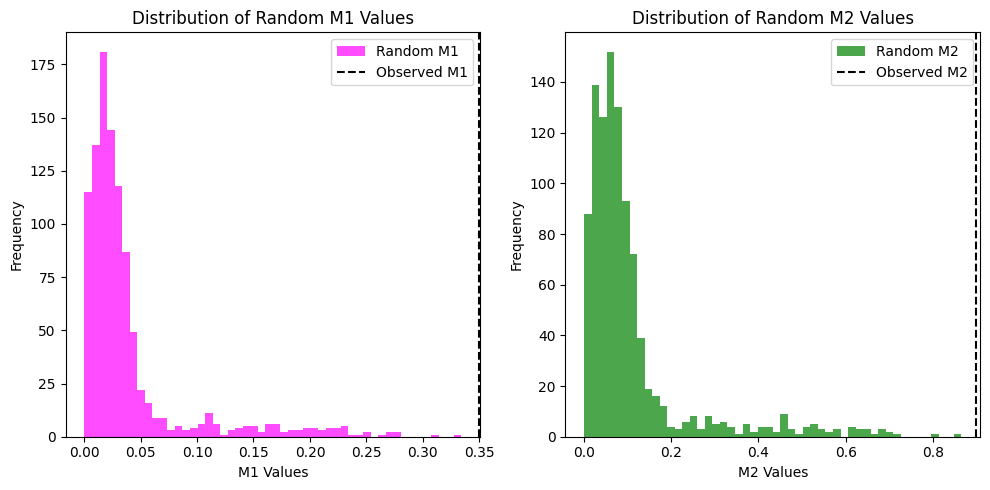

In [48]:
# plot the distribution of random M1 and M2 values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(random_m1_values, bins=50, color="magenta", alpha=0.7, label="Random M1")
plt.axvline(M1, color="k", linestyle="--", label="Observed M1")
plt.xlabel("M1 Values")
plt.ylabel("Frequency")
plt.title("Distribution of Random M1 Values")
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(random_m2_values, bins=50, color="green", alpha=0.7, label="Random M2")
plt.axvline(M2, color="k", linestyle="--", label="Observed M2")
plt.xlabel("M2 Values")
plt.ylabel("Frequency")
plt.title("Distribution of Random M2 Values")
plt.legend()
plt.tight_layout()
plt.show()

### Summary

The Python implementation for calculating Mander's Correlation Coefficients is straightforward and concise, as demonstrated in the code below. However, it's crucial to remember that these coefficients are highly sensitive to thresholding methods. The choice of thresholding strategy will significantly impact your results, making careful threshold selection essential for accurate colocalization analysis.

```python
# Create binary mask for channel 1 & 2 using a thresholding method of choice
threshold_ch1, threshold_ch2 = threshold_method(ch1, ch2)
image_1_mask = ch1 > threshold_ch1
image_2_mask = ch2 > threshold_ch2

# Find pixels that are above threshold in both channels
overlap_mask = image_1_mask & image_2_mask

# Extract channel 1 & 2 intensities only from overlapping regions
ch1_coloc = ch1[overlap_mask]
ch2_coloc = ch2[overlap_mask]

# Extract all channel 1 & 2 intensities above threshold
ch1_tr = ch1[image_1_mask]
ch2_tr = ch2[image_2_mask]

# Calculate total intensity of channel 1 & 2 above threshold
sum_ch1_tr = np.sum(ch1_tr)
sum_ch2_tr = np.sum(ch2_tr)

# M1: fraction of channel 1 intensity that colocalizes with channel 2
M1 = np.sum(ch1_coloc) / sum_ch1_tr
# M2: fraction of channel 2 intensity that colocalizes with channel 1
M2 = np.sum(ch2_coloc) / sum_ch2_tr
```

Additionally, Mander's coefficients should not be interpreted as absolute values in isolation. Instead, it's always recommended to consider them in the context of comparisons between different conditions, controls, treatments, or experimental groups. The relative changes and ratios between conditions are often more meaningful than the absolute coefficient values themselves.

Finally, it is a good idea to run some statistical tests to validate the significance of your colocalization results, such as the image translation randomization test we implemented above. This will help you assess whether your observed colocalization is statistically significant or could have occurred by chance.